<a href="https://colab.research.google.com/github/abiel2020/RIT_ML/blob/main/Yemane_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount("/content/gdrive")
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

#Homework 8
In this homework, we will write Gradient Boosting class and apply it to the date from the insuarance company about hospitalization chance. After transformation, data are numpy arrays, not dataframes.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/refs/heads/main/2023_fall/Hospital.csv')
#data.head()

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [ ]:
X_train_transformed = transform.fit_transform(X_train)
X_val_transformed = transform.transform(X_val)
X_test_transformed = transform.transform(X_test)

#Gradient Boosting

$$
a_N(x) = b_0(x)+\sum_{n=1}^N \gamma_n b_n(x) = b_0(x) + \gamma_1 b_1(x) +\ldots + \gamma_N b_N(x)
$$
Prediction is
$$
\hat{y}=\operatorname{sign} a_N(x).
$$

After you built this sum, next model $b_{N+1}(x)$ is trained on
$$
s^{(i)} = -\eta\left.\frac{\partial L(y, z)}{\partial z}\right|_{z=a_N(x^{(i)})}.
$$

After that, $\gamma_{N+1}$ is chosen from the following condition:
$$
L(y, a_N(x)+\gamma_{N+1}b_{N+1}(x)) \to \underset{\gamma_{N+1}}{\min}.
$$

##Q1 (12 pt). Implement boosting for binary classification.

Since gradient boosting is trained by sequentially creating models, it may happen that the model that is optimal in terms of generalization is obtained at an intermediate iteration. Usually, to control this behavior, a validation dataset is also passed to the `fit` method, which allows you to assess the overall model quality during training. In addition, it's not usefull to train a really deep model with 1000 or more trees if the optimal ensemble was achieved, for example, at the 70th iteration and did not improve for some number of iterations. Therefore, we will also use early stopping if there are no improvements over a certain number of iterations.

You will fill-in three things:

1 (4 pt). Function `_fit_new_model`

2 (4 pt). Early stopping in `fit`

3 (4 pt). Function `predict_proba` (Convert $a(x)$ into probability as in logistic regression).

In [ ]:
class Boosting:

    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None
    ):

        # Base model class
        self.base_model_class = base_model_class
        # Parameters for the base model
        self.base_model_params = base_model_params
        # Number of the base models
        self.n_estimators = n_estimators
        # Learnin rate (eta)
        self.learning_rate = learning_rate
        # Fraction of the training data for training of the individual model
        self.subsample = subsample
        # seed for bootstrap (if we want to reproduse the model, we could use it in base_model parameters)
        self.random_seed = random_seed
        # Use the number of models with the lowest validation loss
        self.use_best_model = use_best_model
        # The number of iterations without decreasing of the validation loss
        self.n_iter_early_stopping = n_iter_early_stopping

        # Placeholder for the first model prediction (a_0)
        self.initial_model_pred = None

        # Lis of the weights
        self.gammas = []

        # List of the base models
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]

        # Log-loss, if user's loss, then pass list: custom_loss = [loss, derivative]
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()  #for two arrays returns a number
            self.loss_derivative = lambda y, z: (-y * self.sigmoid(-y * z)) #for two arrays returns an array

    def _fit_initial_model(self, X, y):
        """
        Function for the first model. It can be a constant, corresponding to the most popular class
        or any other model. We will use a constant.
        """

        idx = random.sample(range(X.shape[0]), int(self.subsample*X.shape[0]))
        X_s = X[idx,:]
        y_s = y[idx]

        c, c_counts = np.unique(y_s, return_counts=True)

        self.initial_model_pred = c[np.argmax(c_counts)]


    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, old_predictions: np.ndarray, n_model: int):
    # Take the fraction self.subsample of the data
        n_samples = X.shape[0]
        n_subsample = int(self.subsample * n_samples)
        indices = np.random.choice(n_samples, size=n_subsample, replace=False)
        X_subset = X[indices]
        y_subset = y[indices]
        old_predictions_subset = old_predictions[indices]

        # Compute pseudo-residuals using negative loss derivative
        pseudo_residuals = -self.loss_derivative(y_subset, old_predictions_subset)

        # Fit n-th base model on the subset
        self.models[n_model].fit(X_subset, pseudo_residuals)




    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Function determines the best  gamma (the coeffitient for the new model).
        :param y: target
        :param old_predictions: prediction from the sum of previous models
        :param new_predictions: prediction of the new model
        :param boudnaries: array-like object with left and right boundaries for gamma
        """
        # Define initial loss and gamma
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Gridsearch for gamma
        gammas = np.linspace(*boundaries, 100)
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss

        return optimal_gamma


    def fit(self, X, y, eval_set=None):
        """
        Function of the training the boosting model
        :param X: features (n_elments, n_features)
        :param y: target (n_elements, )
        :eval_set: tuple (X_val, y_val) or None
        """
        early_stop = np.zeros(self.n_iter_early_stopping)
        self._fit_initial_model(X,y)
        old_predictions = self.initial_model_pred*np.ones(len(y))
        self.loss = []
        self.loss_eval = []
        if eval_set != None:
            predictions_eval = self.initial_model_pred*np.ones(len(eval_set[1]))
        for i in range(self.n_estimators):
            # fit new model
            self._fit_new_model(X,y,old_predictions,i)
            # prediction of the i-th model
            new_predictions = self.models[i].predict(X)
            # calculate new gamma
            opt_gamma = self._find_optimal_gamma(y,old_predictions,new_predictions)
            self.gammas.append(opt_gamma)
            # update a(x)
            old_predictions = old_predictions + opt_gamma*new_predictions
            # calculate loss
            self.loss.append(self.loss_fn(y, old_predictions))
            # in case of evaluation set
            if eval_set != None:
                predictions_eval = predictions_eval + self.gammas[i]*self.models[i].predict(eval_set[0])
                self.loss_eval.append(self.loss_fn(eval_set[1], predictions_eval))
                print('test_loss:', self.loss_eval[i], '  train_loss:', self.loss[i])

                # Update early stopping array
                early_stop = np.roll(early_stop, -1)
                early_stop[-1] = self.loss_eval[i]

                # Check if all values are close to current loss
                if np.all(np.abs(early_stop - self.loss_eval[i]) < 0.001):
                    print(f'Early stopping at iteration {i}')
                    break
            else:
                print('train_loss:', self.loss[i])
        if (eval_set != None) and self.use_best_model:
             self.gammas = self.gammas[:np.argmin(self.loss_eval)+1]



    def predict(self, X: np.ndarray):
        """
        Function that predicts the classes
        :param X: feature matrix
        """

        pred = self.initial_model_pred*np.ones(len(X)) #.predict(X)
        for i in range(len(self.gammas)):
          pred = pred+self.gammas[i]*self.models[i].predict(X)
        return np.sign(pred)

    def predict_proba(self, X: np.ndarray):
        """
        Function predicts probabilities of class +1
        :param X: feature matrix
        """
        # Get raw predictions
        raw_predictions = self.initial_model_pred * np.ones(len(X))
        for i in range(len(self.gammas)):
            raw_predictions += self.gammas[i] * self.models[i].predict(X)

        # Convert to probabilities using sigmoid
        probabilities = self.sigmoid(raw_predictions)
        return probabilities


    @property
    def feature_importances_(self):
        """
        Extra credits (+3 pt)
        Function calculates feature importance.
        And it should be an attribute of the class
        """
        importance = np.zeros(self.models[0].n_features_in_)
        for model, gamma in zip(self.models, self.gammas):
            importance += gamma * model.feature_importances_
        return importance / np.sum(importance)

The following cell will run your class. It should take about 10 seconds

In [ ]:
%%time

boosting = Boosting(n_estimators = 1000, n_iter_early_stopping = 6, use_best_model=True)
boosting.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val))

test_loss: 0.4444876624029337   train_loss: 0.4305290736422778
test_loss: 0.42543362300539656   train_loss: 0.407369734620744
test_loss: 0.4140912666771695   train_loss: 0.3917408792790221
test_loss: 0.40542495851027105   train_loss: 0.3804688793231079
test_loss: 0.4005231680354617   train_loss: 0.37164513794520004
test_loss: 0.39745369796527574   train_loss: 0.3651445351732163
test_loss: 0.39421292932441726   train_loss: 0.3601196527677103
test_loss: 0.39252533032641473   train_loss: 0.3561837129530908
test_loss: 0.38947156034296315   train_loss: 0.3525884790397326
test_loss: 0.3883274695603108   train_loss: 0.34996363992402457
test_loss: 0.3875979072022902   train_loss: 0.34766188049109287
test_loss: 0.3873321782366549   train_loss: 0.3455241112148803
test_loss: 0.3885122814490222   train_loss: 0.3438946826955453
test_loss: 0.38849836781673813   train_loss: 0.34247698085810846
test_loss: 0.38822288810174915   train_loss: 0.34138100203088706
Early stopping at iteration 14
CPU times: u

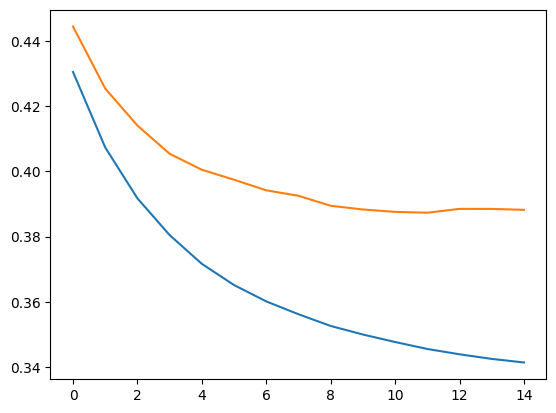

In [ ]:
plt.plot(boosting.loss)
plt.plot(boosting.loss_eval)

## Q2 (4 pt). Use your trained Boosting classifier.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, boosting.predict_proba(X_val_transformed)>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay

In [ ]:
# (a) Find the optimal threshold
thresholds = np.linspace(0, 1, 100)
recalls = [recall_score((y_val + 1) // 2, boosting.predict_proba(X_val_transformed) > t) for t in thresholds]

In [ ]:
optimal_threshold = thresholds[np.argmin(np.abs(np.array(recalls) - 0.5))]
print(f"Optimal threshold for recall ~0.5: {optimal_threshold}")

Optimal threshold for recall ~0.5: 0.24242424242424243


Recall on Test set: 0.5190397350993378


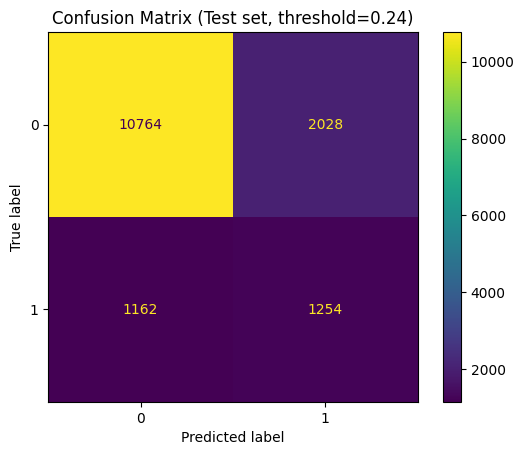

In [ ]:
y_pred_test = (boosting.predict_proba(X_test_transformed) > optimal_threshold).astype(int)
custom_test_recall = recall_score((y_test + 1) // 2, y_pred_test)
print(f"Recall on Test set: {custom_test_recall}")
ConfusionMatrixDisplay.from_predictions((y_test + 1) // 2, y_pred_test)
plt.title(f"Confusion Matrix (Test set, threshold={optimal_threshold:.2f})")
plt.show()

In [ ]:
boosting.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val))
RocCurveDisplay.from_estimator(boosting, X_test_transformed, (y_test + 1) // 2)
plt.title("ROC Curve (Test set)")
plt.show()

test_loss: 0.44399751330835086   train_loss: 0.4298681842937569
test_loss: 0.42595441734690526   train_loss: 0.4065026642834617
test_loss: 0.4150692897129118   train_loss: 0.39055603805448413
test_loss: 0.40699029740735143   train_loss: 0.37857642078980885
test_loss: 0.4013575417579126   train_loss: 0.37031547307414736
test_loss: 0.3980454688135717   train_loss: 0.3641225678122309
test_loss: 0.39495205139076056   train_loss: 0.35898420983544793
test_loss: 0.39263092694955803   train_loss: 0.3552305135201544
test_loss: 0.39118151782675137   train_loss: 0.351983104934243
test_loss: 0.3899494741130258   train_loss: 0.3494665651773383
test_loss: 0.3891398568217782   train_loss: 0.34723648776246113
test_loss: 0.38840172784498045   train_loss: 0.3454386432334657
test_loss: 0.3875969758640797   train_loss: 0.3439217184912229
test_loss: 0.38739333455796354   train_loss: 0.3426044977032382
test_loss: 0.3872130185468164   train_loss: 0.34137317855720667
test_loss: 0.3867863810775441   train_loss

NotFittedError: This Boosting instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Q3 (4 pt). Train LightGBM Classifier on your data.
(a) Choose the threshold form (0, 1) to get recall $\approx 0.5$ on the validation set.

`recall_score((y_val+1)//2, gb.predict_proba(X_val_transformed)[:,1]>threshhold)`

(b) Plot Confusion Matrix for the Test based on this threshhold and calculate recall on Test.

(c) Plot ROC curve

`RocCurveDisplay.from_predictions(y_test, gb.predict_proba(X_test_transformed)[:,1])`

(d) Compare with the result of your model from Q2.

In [ ]:
import lightgbm as lgb

In [ ]:
gb = lgb.LGBMClassifier()

In [ ]:

gb.fit(X_train_transformed, y_train)

thresholds = np.linspace(0, 1, 100)
recalls = [recall_score((y_val + 1) // 2, gb.predict_proba(X_val_transformed)[:, 1] > t) for t in thresholds]
optimal_threshold = thresholds[np.argmin(np.abs(np.array(recalls) - 0.5))]
print(f"Optimal threshold for recall ~0.5: {optimal_threshold}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6920, number of negative: 38702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 45622, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151681 -> initscore=-1.721476
[LightGBM] [Info] Start training from score -1.721476


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Optimal threshold for recall ~0.5: 0.27272727272727276


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Recall on Test set: 0.5206953642384106


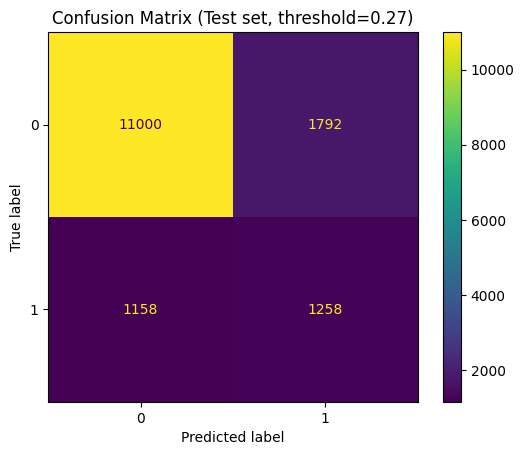

In [ ]:
# (b) Confusion Matrix and Recall on Test set
y_pred_test = (gb.predict_proba(X_test_transformed)[:, 1] > optimal_threshold).astype(int)
lightgbm_test_recall = recall_score((y_test + 1) // 2, y_pred_test)
print(f"Recall on Test set: {lightgbm_test_recall}")
ConfusionMatrixDisplay.from_predictions((y_test + 1) // 2, y_pred_test)
plt.title(f"Confusion Matrix (Test set, threshold={optimal_threshold:.2f})")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


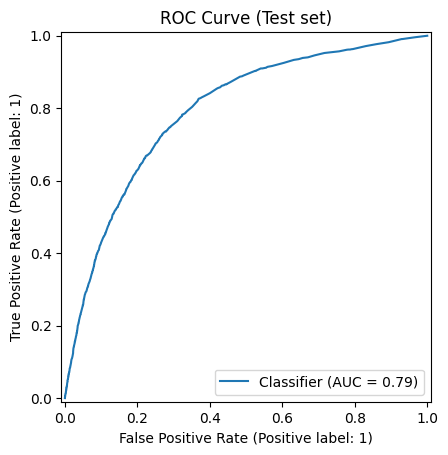

In [ ]:
# (c) ROC Curve
RocCurveDisplay.from_predictions(y_test, gb.predict_proba(X_test_transformed)[:, 1])
plt.title("ROC Curve (Test set)")
plt.show()


The LightGBM Model displayed a higher test recall generally indicating a better performance in correctly identifying positive cases

In [ ]:
print(f"Custom Boosting Model Test Recall: {custom_test_recall}") # from previous cell
print(f"LightGBM Model Test Recall: {lightgbm_test_recall}") # from previous cell

Custom Boosting Model Test Recall: 0.5190397350993378
LightGBM Model Test Recall: 0.5206953642384106


Are you satisfied with the result?

The LightGBM model's test recall (0.52) is slightly better than the custom boosting model's test recall (0.51).  While a small difference, it suggests LightGBM performed marginally better in this specific case at identifying the positive class.  Whether this difference is significant enough to warrant using LightGBM over the custom model depends on the specific application and the cost of misclassifications.  Further analysis, potentially with different hyperparameters or evaluation metrics, might be needed to draw more definitive conclusions.
